# Analysis of workloads fib-r and fib-i (Startup time and running time)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

plt.style.use('ggplot')

In [2]:
mx = pd.read_csv("Metrics.csv", index_col=["workload_type", "platform", "workload_size", "rep_id"])

#clean up columns

mx["startup_time_ms"] =  mx["startup_time_us"] / 1000
mx["completion_time_ms"] =  mx["completion_time_us"] / 1000
mx["running_time_ms"] =  mx["running_time_us"] / 1000
mx.drop(columns=["startup_time_us","completion_time_us", "running_time_us", "stop_time_us", "http_metrics","run_id"], inplace=True)

mx = mx.rename(index={"FIB_RECURSIVE": "fib-r", "FIB_ITERATIVE": "fib-i"})
mx = mx.rename(index={"CONTAINERED_WASMTIME": "DOCKER_WASMTIME", "CONTAINERED_WASMER": "DOCKER_WASMER"})
mx

startup_time_ms  \
workload_type platform      workload_size rep_id                    
fib-r         DOCKER_WASMER SMALL         0               323.020   
                                          1               315.813   
                                          2               323.275   
                                          3               353.655   
                                          4               339.034   
...                                                           ...   
fib-i         K8S_WASMTIME  LARGE         20              767.316   
                                          21              742.811   
                                          22              794.243   
                                          23              805.872   
                                          24              753.148   

                                                  completion_time_ms  \
workload_type platform      workload_size rep_id                       
fib-r         DOCKER_WASMER SMALL         0                  440.507   
                                          1                  464.216   
                                          2                  467.875   
                                          3                  496.708   
                                          4                  502.747   
...                                                              ...   
fib-i         K8S_WASMTIME  LARGE         20                1786.679   
                                          21                1788.071   
                                          22                1747.279   
                                          23                1752.360   
                                          24                1752.004   

                                                  running_time_ms  
workload_type platform      workload_size rep_id                   
fib-r         DOCKER_WASMER SMALL         0               117.487  
                                          1               148.403  
                                          2               144.600  
                                          3               143.053  
                                          4               163.713  
...                                                           ...  
fib-i         K8S_WASMTIME  LARGE         20             1019.363  
                                          21             1045.260  
                                          22              953.036  
                                          23              946.488  
                                          24              998.856  

[1475 rows x 3 columns]

## How do the startup times compare (Mean over both workload types and workload sizes)?


In [3]:
s_times = mx.groupby(["platform"]).mean().unstack()[["startup_time_ms"]]
s_times

                 platform       
startup_time_ms  CLI_WASMER           23.098220
                 CLI_WASMTIME         23.331213
                 DOCKER_WASMER       358.607647
                 DOCKER_WASMTIME     360.533087
                 K8S_WASMER          772.846913
                 K8S_WASMTIME        800.916333
                 KRUSTLET            961.841460
                 VINO                 27.282467
                 WASMCLOUD          3219.934847
                 WASMEDGE_ON_K8S     910.312968
dtype: float64

### Increase factors based on fastest startup time

In [4]:
min = s_times.min()
s_times.div(min)

                 platform       
startup_time_ms  CLI_WASMER           1.000000
                 CLI_WASMTIME         1.010087
                 DOCKER_WASMER       15.525337
                 DOCKER_WASMTIME     15.608696
                 K8S_WASMER          33.459155
                 K8S_WASMTIME        34.674375
                 KRUSTLET            41.641367
                 VINO                 1.181150
                 WASMCLOUD          139.401861
                 WASMEDGE_ON_K8S     39.410525
dtype: float64

### How are the startup times distributed? (Over both workload types and all sizes)

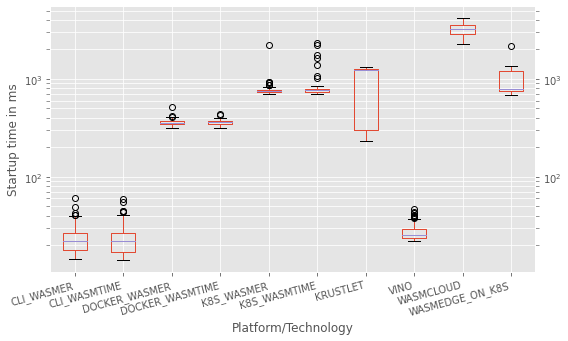

In [5]:
ax = mx.boxplot(column=["startup_time_ms"], by=["platform"], figsize=(8,5))
ax.set(yscale="log", ylabel="Startup time in ms", xlabel="Platform/Technology", title="")
ax.yaxis.grid(True, which="both")
ax.tick_params(labeltop=False, labelright=True, right=True, which="both", length=4)
plt.setp(ax.get_xticklabels(), rotation=15, ha="right")
plt.suptitle('') #remove upper title
ax.get_figure().tight_layout()
plt.savefig("images/startup.svg")
pass

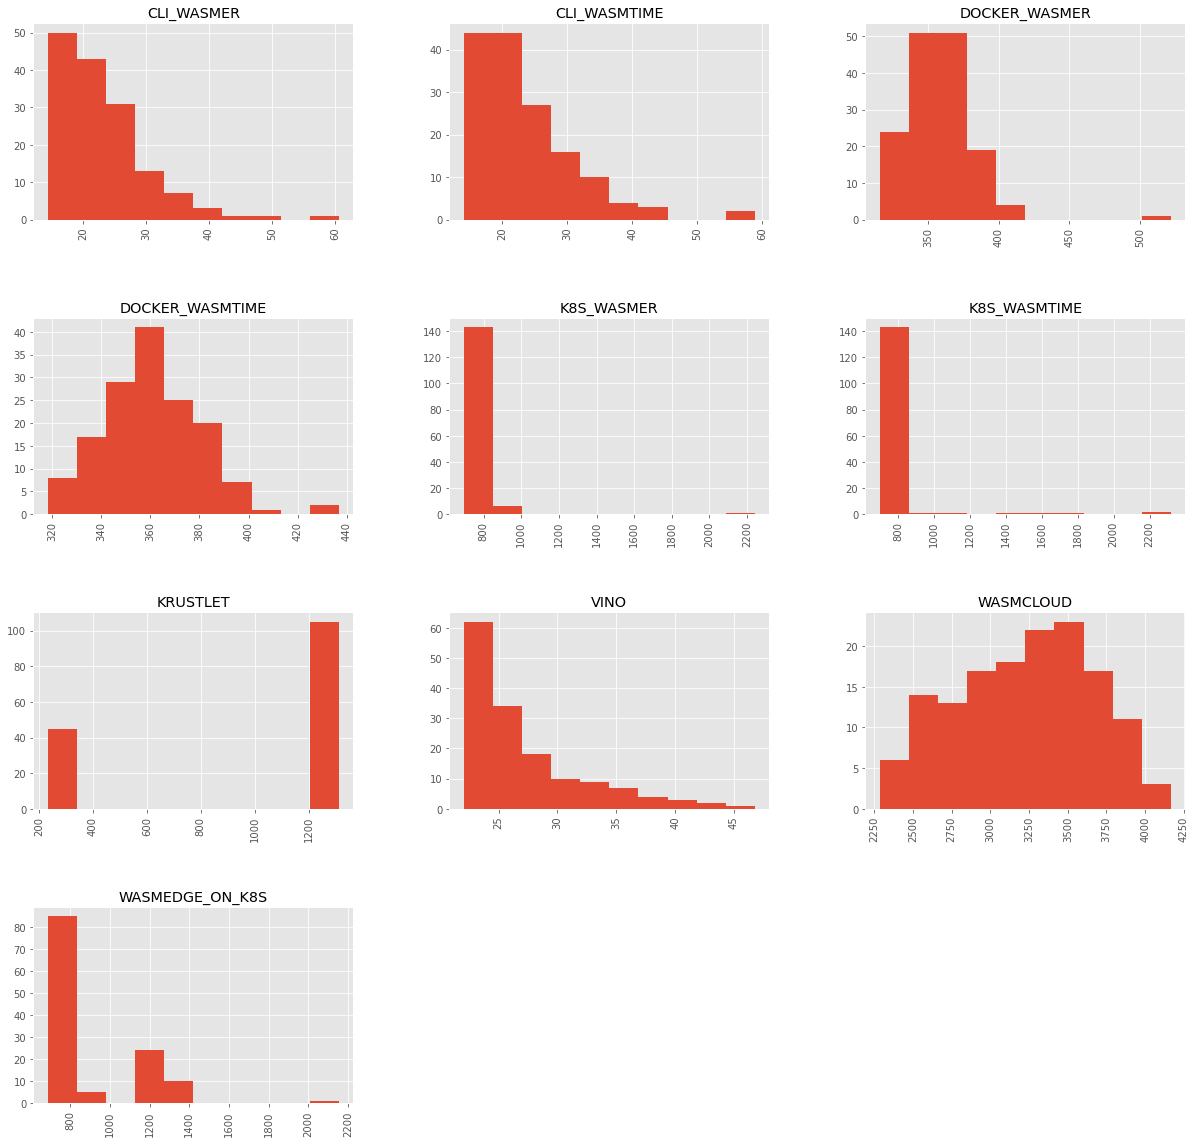

In [6]:
mx["startup_time_ms"].hist(by="platform", figsize=(20,20) )
pass

In [7]:
mx.groupby("platform")["startup_time_ms"].describe()

count         mean         std       min         25%  \
platform                                                                
CLI_WASMER       150.0    23.098220    7.324307    14.434    17.71775   
CLI_WASMTIME     150.0    23.331213    7.874530    14.149    17.06375   
DOCKER_WASMER    150.0   358.607647   24.183699   315.813   343.31650   
DOCKER_WASMTIME  150.0   360.533087   19.944495   318.393   345.50475   
K8S_WASMER       150.0   772.846913  126.642564   694.443   739.20725   
K8S_WASMTIME     150.0   800.916333  214.314887   699.576   741.17650   
KRUSTLET         150.0   961.841460  447.037783   233.257   303.05250   
VINO             150.0    27.282467    4.984983    22.045    23.78350   
WASMCLOUD        144.0  3219.934847  432.538472  2286.603  2898.41125   
WASMEDGE_ON_K8S  125.0   910.312968  247.251872   686.382   749.21000   

                       50%         75%       max  
platform                                          
CLI_WASMER         21.8660    26.59675    60.633  
CLI_WASMTIME       21.8910    26.61825    58.857  
DOCKER_WASMER     356.8380   368.89000   521.703  
DOCKER_WASMTIME   359.6240   372.27600   436.709  
K8S_WASMER        757.9415   776.03925  2241.943  
K8S_WASMTIME      761.9985   782.57450  2317.165  
KRUSTLET         1235.7255  1260.43025  1311.942  
VINO               25.3415    29.26725    46.769  
WASMCLOUD        3257.6830  3565.44325  4165.172  
WASMEDGE_ON_K8S   789.9840  1192.85000  2153.636

### Median startup time of platforms

In [8]:
mx.groupby("platform")["startup_time_ms"].median()

platform
CLI_WASMER           21.8660
CLI_WASMTIME         21.8910
DOCKER_WASMER       356.8380
DOCKER_WASMTIME     359.6240
K8S_WASMER          757.9415
K8S_WASMTIME        761.9985
KRUSTLET           1235.7255
VINO                 25.3415
WASMCLOUD          3257.6830
WASMEDGE_ON_K8S     789.9840
Name: startup_time_ms, dtype: float64

## How does the running times compare? 
Only workload_size SMALL and MEDIUM are used where means are calculate because WASMEDGE_ON_K8S failed for LARGE, thus the running_time_ms comparison would not be fair

In [9]:
s_times = mx.groupby(["platform", "workload_type", "workload_size"]).mean().unstack().unstack()[["running_time_ms"]]
s_times

running_time_ms                                        \
workload_size             LARGE                   MEDIUM                
workload_type             fib-i       fib-r        fib-i        fib-r   
platform                                                                
CLI_WASMER              1.52512  3013.21980     1.490920    281.11592   
CLI_WASMTIME            1.02712  3739.33520     1.308000    345.50156   
DOCKER_WASMER         154.20268  3156.42048   151.998680    420.19420   
DOCKER_WASMTIME       155.47964  3719.63412   151.337840    470.15200   
K8S_WASMER            987.78424  4023.46712   961.251200   1003.92288   
K8S_WASMTIME         1008.36628  4023.49640   996.096000   1003.99948   
KRUSTLET               48.29204  6620.45280    46.599120    671.97264   
VINO                   61.53456  4197.69108     6.896440    407.46296   
WASMCLOUD            1539.07824  4924.06824  1697.914826   1927.63760   
WASMEDGE_ON_K8S       866.23336         NaN   889.755480  25722.86864   

                                           
workload_size          SMALL               
workload_type          fib-i        fib-r  
platform                                   
CLI_WASMER          1.415520     1.861960  
CLI_WASMTIME        1.286400     1.470000  
DOCKER_WASMER     148.966720   145.649760  
DOCKER_WASMTIME   147.795720   149.951360  
K8S_WASMER        975.084120   968.338120  
K8S_WASMTIME      915.380920   882.664400  
KRUSTLET           51.546160    49.762680  
VINO                6.601520     6.640160  
WASMCLOUD        1603.561682  1623.579292  
WASMEDGE_ON_K8S   807.792920   764.242040

### Increase factors of running based on fastest platform of each workload/size

In [10]:
min = s_times.min()
s_times.div(min)

running_time_ms                                    \
workload_size             LARGE                 MEDIUM              
workload_type             fib-i     fib-r        fib-i      fib-r   
platform                                                            
CLI_WASMER             1.484851  1.000000     1.139847   1.000000   
CLI_WASMTIME           1.000000  1.240977     1.000000   1.229036   
DOCKER_WASMER        150.131124  1.047524   116.206942   1.494736   
DOCKER_WASMTIME      151.374367  1.234438   115.701713   1.672449   
K8S_WASMER           961.702858  1.335272   734.901529   3.571206   
K8S_WASMTIME         981.741452  1.335281   761.541284   3.571479   
KRUSTLET              47.016941  2.197136    35.626239   2.390376   
VINO                  59.909806  1.393092     5.272508   1.449448   
WASMCLOUD           1498.440533  1.634155  1298.100020   6.857092   
WASMEDGE_ON_K8S      843.361399       NaN   680.241193  91.502710   

                                           
workload_size          SMALL               
workload_type          fib-i        fib-r  
platform                                   
CLI_WASMER          1.100373     1.266639  
CLI_WASMTIME        1.000000     1.000000  
DOCKER_WASMER     115.801244    99.081469  
DOCKER_WASMTIME   114.890951   102.007728  
K8S_WASMER        757.994496   658.733415  
K8S_WASMTIME      711.583427   600.451973  
KRUSTLET           40.070087    33.852163  
VINO                5.131779     4.517116  
WASMCLOUD        1246.549815  1104.475709  
WASMEDGE_ON_K8S   627.948476   519.892544

### Distribution of running times, by size and workload

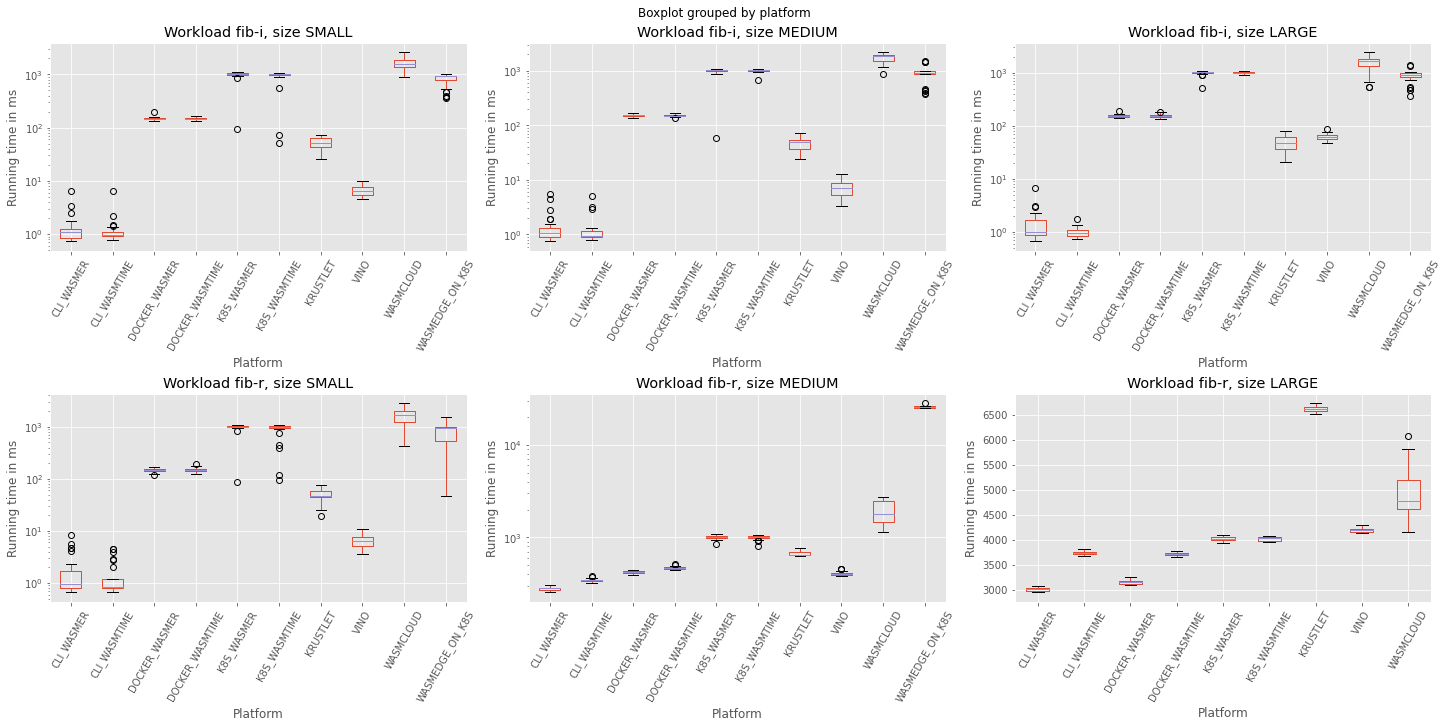

In [11]:
ds = mx["running_time_ms"]
sizes = ["SMALL", "MEDIUM", "LARGE"]
types = ["fib-i", "fib-r"]

fig, axs = plt.subplots(len(types),len(sizes), figsize=(20,10), constrained_layout=True)

for count, (_type, size) in enumerate(product(types,sizes)):
    ax = mx.loc[(_type, slice(None), size)] \
      .boxplot(column=["running_time_ms"], by="platform", ax=axs.flatten()[count], rot=60)
    if _type != "fib-r" or size != "LARGE":
        ax.set(yscale="log")
    ax.set(xlabel="Platform",ylabel="Running time in ms", title=f"Workload {_type}, size {size}")
    

### How do the running times of the FIB-R workload compare? (Mean) 

In [12]:
g = mx.loc[("fib-r")].groupby(by=["platform", "workload_size"]).mean().unstack()

g["running_time_ms"]

workload_size         LARGE       MEDIUM        SMALL
platform                                             
CLI_WASMER       3013.21980    281.11592     1.861960
CLI_WASMTIME     3739.33520    345.50156     1.470000
DOCKER_WASMER    3156.42048    420.19420   145.649760
DOCKER_WASMTIME  3719.63412    470.15200   149.951360
K8S_WASMER       4023.46712   1003.92288   968.338120
K8S_WASMTIME     4023.49640   1003.99948   882.664400
KRUSTLET         6620.45280    671.97264    49.762680
VINO             4197.69108    407.46296     6.640160
WASMCLOUD        4924.06824   1927.63760  1623.579292
WASMEDGE_ON_K8S         NaN  25722.86864   764.242040

### Running times of workload fib-r by workload size, error bars show SD

/home/jonas/mambaforge/envs/analysis/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/jonas/mambaforge/envs/analysis/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


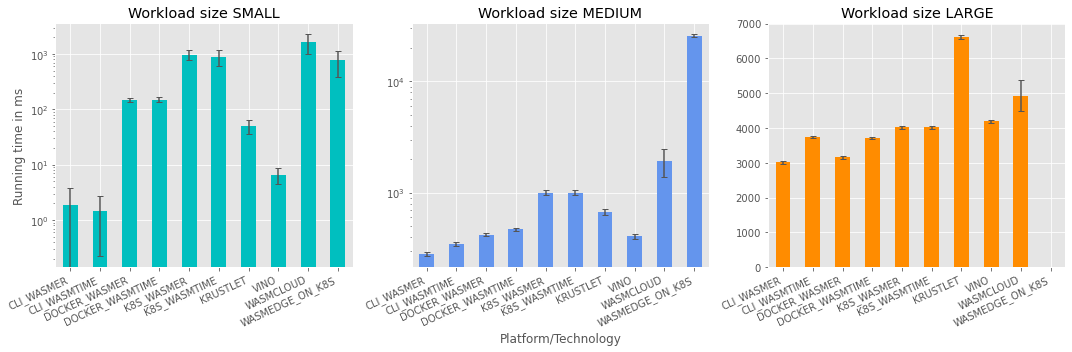

In [13]:
d = mx["running_time_ms"].loc[("fib-r")].groupby(["platform", "workload_size"])
mean = d.mean().unstack()[["SMALL", "MEDIUM", "LARGE"]]
std = d.std().unstack()[["SMALL", "MEDIUM", "LARGE"]]

axs = mean.plot.bar(subplots=True, layout=(1,3), figsize=(15,5), sharex=False, rot=30, yerr=std, capsize=3, legend=False, color=["c", "cornflowerblue", "darkorange"])
for subax in axs:
    for ax in subax: 
        plt.setp(ax.get_xticklabels(), rotation=25, ha="right")
        ax.set(xlabel="")

axs[0][0].get_figure().tight_layout()
axs[0][0].set(yscale="log", title="Workload size SMALL", ylabel="Running time in ms")
axs[0][1].set(yscale="log", title="Workload size MEDIUM", xlabel="Platform/Technology")
axs[0][2].set(title="Workload size LARGE")
ax.get_figure().tight_layout()
plt.savefig("images/fib-r.svg")
pass

### Running times of workload fib-i by workload size, error bars show SD

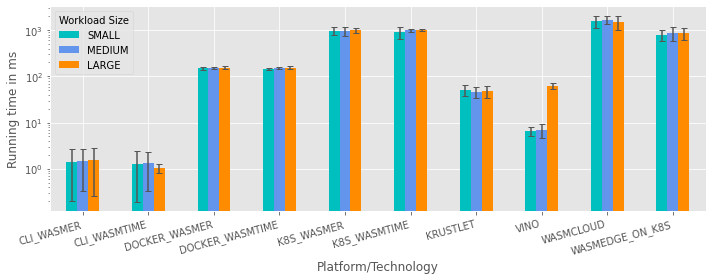

In [14]:
d = mx["running_time_ms"].loc[("fib-i")].groupby(["platform", "workload_size"])
mean = d.mean().unstack()[["SMALL", "MEDIUM", "LARGE"]]
std = d.std().unstack()[["SMALL", "MEDIUM", "LARGE"]]

ax = mean.plot.bar(layout=(1,3), figsize=(10,4), sharex=False, yerr=std, capsize=3, color=["c", "cornflowerblue", "darkorange"])
plt.setp(ax.get_xticklabels(), rotation=15, ha="right")
ax.set(yscale="log", ylabel="Running time in ms", xlabel="Platform/Technology", title="")
ax.legend(title="Workload Size")

ax.get_figure().tight_layout()
plt.savefig("images/fib-i.svg")
pass

### Mean running times of workload fib-i by workload size

In [15]:
mx.loc[("fib-i")].groupby(["platform", "workload_size"]).mean()["running_time_ms"]

platform         workload_size
CLI_WASMER       LARGE               1.525120
                 MEDIUM              1.490920
                 SMALL               1.415520
CLI_WASMTIME     LARGE               1.027120
                 MEDIUM              1.308000
                 SMALL               1.286400
DOCKER_WASMER    LARGE             154.202680
                 MEDIUM            151.998680
                 SMALL             148.966720
DOCKER_WASMTIME  LARGE             155.479640
                 MEDIUM            151.337840
                 SMALL             147.795720
K8S_WASMER       LARGE             987.784240
                 MEDIUM            961.251200
                 SMALL             975.084120
K8S_WASMTIME     LARGE            1008.366280
                 MEDIUM            996.096000
                 SMALL             915.380920
KRUSTLET         LARGE              48.292040
                 MEDIUM             46.599120
                 SMALL              51.546160
VIN

### Running times of workload fib-i by platform (no separation of workload sizes)

In [16]:
mx["running_time_ms"].loc[("fib-i")].groupby(["platform"]).describe()

count         mean         std      min        25%       50%  \
platform                                                                        
CLI_WASMER        75.0     1.477187    1.200349    0.671     0.8850     1.046   
CLI_WASMTIME      75.0     1.207173    0.858868    0.745     0.8920     0.956   
DOCKER_WASMER     75.0   151.722693   10.782593  133.194   144.5180   151.691   
DOCKER_WASMTIME   75.0   151.537733    9.424776  133.224   145.9785   150.510   
K8S_WASMER        75.0   974.706520  167.373524   59.212   975.7385  1009.414   
K8S_WASMTIME      75.0   973.281067  169.154594   51.332   971.8735  1007.621   
KRUSTLET          75.0    48.812440   13.976428   20.858    37.5490    50.164   
VINO              75.0    25.010840   26.562156    3.250     5.5830     7.955   
WASMCLOUD         70.0  1611.533629  442.534695  532.760  1350.1845  1683.841   
WASMEDGE_ON_K8S   75.0   854.593920  254.884772  364.849   809.7095   917.135   

                        75%       max  
platform                               
CLI_WASMER          1.38550     6.741  
CLI_WASMTIME        1.12850     6.370  
DOCKER_WASMER     156.71550   194.141  
DOCKER_WASMTIME   156.71550   182.094  
K8S_WASMER       1038.82350  1094.191  
K8S_WASMTIME     1038.89900  1068.919  
KRUSTLET           60.33850    78.330  
VINO               54.98200    86.739  
WASMCLOUD        1886.29075  2605.806  
WASMEDGE_ON_K8S   967.14750  1494.840